In [1]:
# IMPORT STATEMENTS
import os
import pickle

import matplotlib.pyplot as plt
import tensorflow as tf
from tf_agents.utils import common
from tf_agents.trajectories import trajectory
from tf_agents.policies import random_tf_policy
from tf_agents.environments import tf_py_environment
from tf_agents.networks import categorical_q_network
from tf_agents.policies.policy_saver import PolicySaver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
import numpy as np
from tf_agents.policies import random_tf_policy

from speed_racer import utils
from speed_racer.env import SpeedRacer

tf.compat.v1.enable_v2_behavior()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Run Set-up
env_name = "Speed-Racer" # Episode are ~200-1000
num_iterations = 200000     

log_interval = 200 # how often to record mae
eval_interval = 6000 # how often to eval model
reporting_interval = 2000 # how often to print progress to screen

initial_collect_steps = 2000 
collect_steps_per_iteration = 4
replay_buffer_capacity = 100000  

network_name = 'small'
fc_layer_params = (200,)
batch_size = 64 
learning_rate = 1e-3  
gamma = 0.99       # we want to encourage faster solving so this has to be <1
num_atoms = 51
min_q_value = -300  
max_q_value = 300  
n_step_update = 4

num_eval_episodes = 1
warm_start = True
start_file = 'action_recordings/first_test.pkl'
if warm_start:
    with open(start_file, 'rb') as in_pickle:
        recorded_actions = pickle.load(in_pickle)
    recorded_actions = [tf.convert_to_tensor([action], dtype=np.int64) for action in recorded_actions]

In [3]:
agent_name = f"{env_name}-rl-{num_iterations / 1000:.0f}k-{network_name}-{fc_layer_params[0]}-{n_step_update}n"
print(f"Training {agent_name}")

Training Speed-Racer-rl-200k-small-200-4n


In [4]:
train_py_env = SpeedRacer('hard')
eval_py_env = SpeedRacer('hard')

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [5]:
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

In [6]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

In [7]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())
utils.compute_avg_return(eval_env, random_policy, num_eval_episodes)

-117.35956

In [8]:
warm_start_counter = 0
warm_start_end = len(recorded_actions)
print(f"warm start steps: {warm_start_end}")

warm start steps: 2000


In [9]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)


def collect_step(environment, policy):
    global warm_start_counter
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    if warm_start_counter < warm_start_end:
        action_step = action_step._replace(action=recorded_actions[warm_start_counter])
    warm_start_counter += 1
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy)


dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

In [10]:
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = utils.compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [(0, avg_return)]
losses = [(0, 0)]

for _ in range(50):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience)

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        losses.append((step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = utils.compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        returns.append((step, avg_return))

    if step % reporting_interval == 0:
        print(f"Steps: {step:,}")

In [10]:
with open(f'metrics/rewards/{agent_name}.pkl', 'wb') as out_pickle:
    pickle.dump(returns, out_pickle)
with open(f'metrics/losses/{agent_name}.pkl', 'wb') as out_pickle:
    pickle.dump(losses, out_pickle)

In [11]:
policy = agent.collect_policy
saver = PolicySaver(policy, batch_size=None)
saver.save(f'policies/{agent_name}')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: policies/Speed-Racer-rl-200k-small-200-4n/assets


In [12]:
saved_policy = tf.saved_model.load(f'policies/{agent_name}')
policy_state = saved_policy.get_initial_state(batch_size=3)
utils.make_video('videos/first_train.mp4', 60, saved_policy, eval_env, eval_py_env)
utils.embed_video('videos/first_train.mp4')

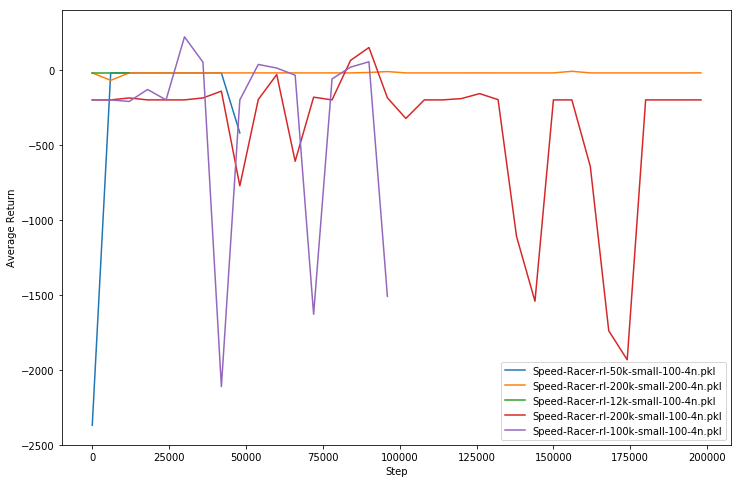

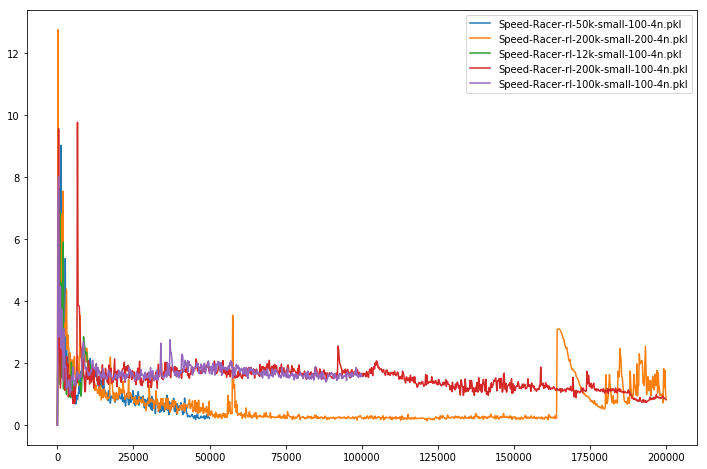

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
for agent_name in os.listdir('metrics/rewards'):
    with open(f'metrics/rewards/{agent_name}', 'rb') as in_pickle:
        rewards = pickle.load(in_pickle)
    steps = [x[0] for x in rewards]
    rewards = utils.smooth_list([x[1] for x in rewards], 1)
    ax.plot(steps, rewards, label=f'{agent_name}')
ax.set_ylabel('Average Return')
ax.set_xlabel('Step')
ax.set_ylim((-2500, 400))

ax.legend()

fig, ax = plt.subplots(figsize=(12, 8))
for agent_name in os.listdir('metrics/losses'):
    with open(f'metrics/losses/{agent_name}', 'rb') as in_pickle:
        losses = pickle.load(in_pickle)
    steps = [x[0] for x in losses]
    losses = utils.smooth_list([x[1] for x in losses], 1)
    ax.plot(steps, losses, label=f'{agent_name}')
#ax.set_ylim((2, 3.2))
ax.legend()